<a href="https://colab.research.google.com/github/mmbs1989/TCC-PUCMINAS/blob/main/Notebook_TCC_PUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>

<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>

<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center><br>
TÍTULO: MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL E DE VARIÁVEIS MACROECONÔMICAS UTILIZANDO SÉRIES TEMPORAIS<br>
<br>
ALUNO: Michel Muglia Barbosa Santos</h3>


In [1]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 7.3MB/s 
     |████████████████████████████████| 9.5MB 27.6MB/s 
     |████████████████████████████████| 2.1MB 44.1MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DA ARRECADAÇÃO FEDERAL**




In [3]:
# Carregar bibliotecas e ler os arquivos
import pandas as pd 
dfarrec = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfa = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcca.csv")

In [4]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfarrec['arrec'] = dfa['a']
dfarrec.head()

,Data,arrec
0,1994-01,4836
1,1994-02,4343
2,1994-03,4418
3,1994-04,5186
4,1994-05,4732


In [5]:
dfarrec.tail()

,Data,arrec
315,2020-04,101154
316,2020-05,77415
317,2020-06,86258
318,2020-07,115990
319,2020-08,124505


In [6]:
# Retirar as linhas que não serão utilizadas na análise
dfarrec = dfarrec.drop(dfarrec.index[314:])
dfarrec.tail()

,Data,arrec
309,2019-10,135202
310,2019-11,125161
311,2019-12,147501
312,2020-01,174991
313,2020-02,116430


In [7]:
# Transformar o tipo das colunas e definir o index
dfarrec['arrec'] = pd.to_numeric(dfarrec['arrec'])
dfarrec['Data'] = pd.to_datetime(dfarrec['Data'])
dfarrec.set_index('Data', inplace=True)

In [8]:
dfarrec.head()

,arrec
Data,
1994-01-01,4836
1994-02-01,4343
1994-03-01,4418
1994-04-01,5186
1994-05-01,4732


In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfarrec.describe()

,arrec
count,314.000000
mean,54008.878981
std,42247.577509
min,4343.000000
25%,15014.500000
50%,45332.000000
75%,91308.000000
max,174991.000000


In [ ]:
# Confirmar se há valores nulos
dfarrec.isnull().sum()

arrec    0
dtype: int64

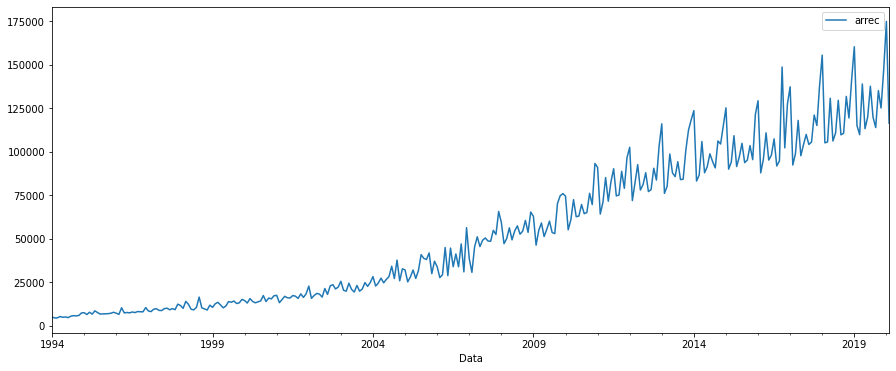

In [9]:
# Gráfico dos valores
dfarrec.plot(figsize=(15,6))

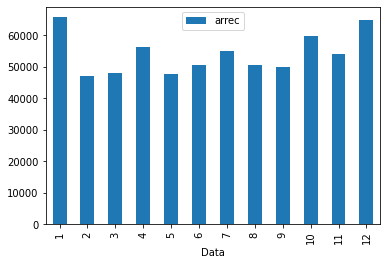

In [10]:
# Análise dos períodos de sazonalidade
dfarrec.groupby(dfarrec.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DO PIB**




In [ ]:
# Carregar bibliotecas e ler os arquivos
import pandas as pd 
dfpib = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccpib.csv")

In [ ]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfpib['pib'] = dfp['pib']
dfpib.head()

,Data,pib
0,1994-01,4563
1,1994-02,5793
2,1994-03,8520
3,1994-04,12829
4,1994-05,20504


In [ ]:
dfpib.tail()

,Data,pib
315,2020-04,543554
316,2020-05,560059
317,2020-06,605147
318,2020-07,631041
319,2020-08,629988


In [ ]:
# Retirar as linhas que não serão utilizadas na análise
dfpib = dfpib.drop(dfpib.index[314:])
dfpib.tail()

,Data,pib
309,2019-10,640907
310,2019-11,634654
311,2019-12,647460
312,2020-01,619785
313,2020-02,608644


In [ ]:
# Transformar o tipo das colunas e definir o index
dfpib['pib'] = pd.to_numeric(dfpib['pib'])
dfpib['Data'] = pd.to_datetime(dfpib['Data'])
dfpib.set_index('Data', inplace=True)

In [ ]:
dfpib.head()

,pib
Data,
1994-01-01,4563
1994-02-01,5793
1994-03-01,8520
1994-04-01,12829
1994-05-01,20504


In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfpib.describe()

,pib
count,314.000000
mean,269371.283439
std,184225.641732
min,4563.000000
25%,101859.000000
50%,216359.000000
75%,448483.500000
max,647460.000000


In [ ]:
# Confirmar se há valores nulos
dfpib.isnull().sum()

pib    0
dtype: int64

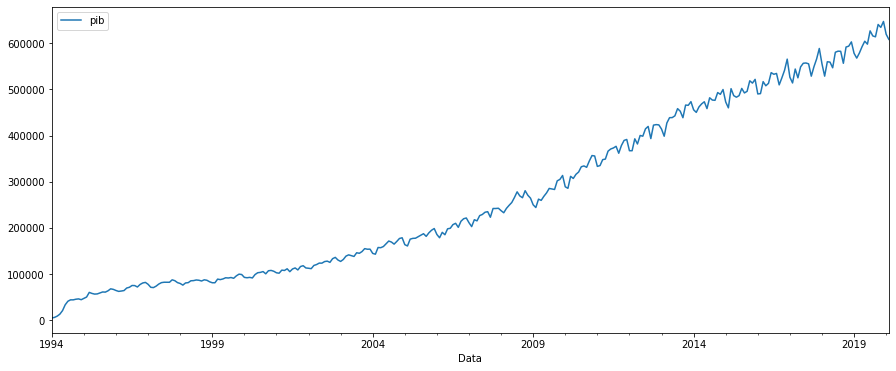

In [ ]:
# Gráfico dos valores
dfpib.plot(figsize=(15,6))

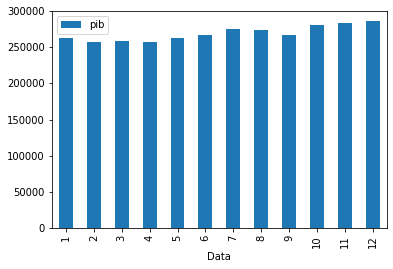

In [ ]:
# Análise dos períodos de sazonalidade
dfpib.groupby(dfpib.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DAS IMPORTAÇÕES**




In [ ]:
# Carregar bibliotecas e ler os arquivos
import pandas as pd 
dfimp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfi = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcci.csv")

In [ ]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfimp['imp'] = dfi['i']
dfimp.head()

,Data,imp
0,1994-01,1768675231
1,1994-02,2030100974
2,1994-03,2248937491
3,1994-04,2151981505
4,1994-05,2624852192


In [ ]:
dfimp.tail()

,Data,imp
315,2020-04,11610871137
316,2020-05,13390915390
317,2020-06,10449294354
318,2020-07,11508172753
319,2020-08,11132508190


In [ ]:
# Retirar as linhas que não serão utilizadas na análise
dfimp = dfimp.drop(dfimp.index[314:])
dfimp.tail()

,Data,imp
309,2019-10,17027283951
310,2019-11,14172102789
311,2019-12,12556086388
312,2020-01,16178224141
313,2020-02,13257290693


In [ ]:
# Transformar o tipo das colunas e definir o index
dfimp['imp'] = pd.to_numeric(dfimp['imp'])
dfimp['Data'] = pd.to_datetime(dfimp['Data'])
dfimp.set_index('Data', inplace=True)

In [ ]:
dfimp.head()

,imp
Data,
1994-01-01,1768675231
1994-02-01,2030100974
1994-03-01,2248937491
1994-04-01,2151981505
1994-05-01,2624852192


In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfimp.describe()

,imp
count,3.140000e+02
mean,9.892423e+09
std,5.810019e+09
min,1.768675e+09
25%,4.618011e+09
50%,8.533477e+09
75%,1.460153e+10
max,2.304960e+10


In [ ]:
# Confirmar se há valores nulos
dfimp.isnull().sum()

imp    0
dtype: int64

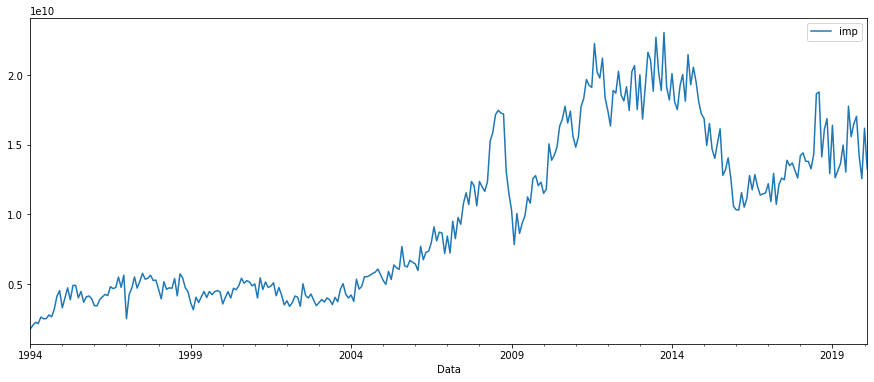

In [ ]:
# Gráfico dos valores
dfimp.plot(figsize=(15,6))

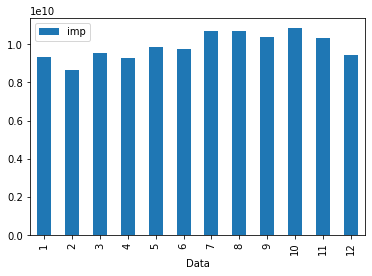

In [ ]:
# Análise dos períodos de sazonalidade
dfimp.groupby(dfimp.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DAS EXPORTAÇÕES**




In [ ]:
# Carregar bibliotecas e ler os arquivos
import pandas as pd 
dfexp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfe = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcce.csv")

In [ ]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfexp['exp'] = dfe['e']
dfexp.head()

,Data,exp
0,1994-01,2747187653
1,1994-02,2778288879
2,1994-03,3350391558
3,1994-04,3634841763
4,1994-05,3862059965


In [ ]:
dfexp.tail()

,Data,exp
315,2020-04,17612476835
316,2020-05,17546386795
317,2020-06,17514983082
318,2020-07,19453592020
319,2020-08,17484221076


In [ ]:
# Retirar as linhas que não serão utilizadas na análise
dfexp = dfexp.drop(dfexp.index[314:])
dfexp.tail()

,Data,exp
309,2019-10,19576839231
310,2019-11,17736715198
311,2019-12,18502977191
312,2020-01,14494583508
313,2020-02,15582390653


In [ ]:
# Transformar o tipo das colunas e definir o index
dfexp['exp'] = pd.to_numeric(dfexp['exp'])
dfexp['Data'] = pd.to_datetime(dfexp['Data'])
dfexp.set_index('Data', inplace=True)

In [ ]:
dfexp.head()

,exp
Data,
1994-01-01,2747187653
1994-02-01,2778288879
1994-03-01,3350391558
1994-04-01,3634841763
1994-05-01,3862059965


In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfexp.describe()

,exp
count,3.140000e+02
mean,1.164247e+10
std,6.617466e+09
min,2.747188e+09
25%,4.632934e+09
50%,1.184663e+10
75%,1.768190e+10
max,2.614824e+10


In [ ]:
# Confirmar se há valores nulos
dfexp.isnull().sum()

exp    0
dtype: int64

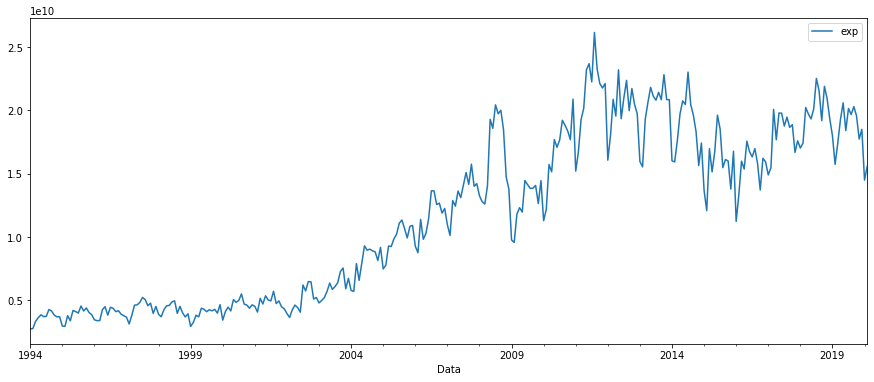

In [ ]:
# Gráfico dos valores
dfexp.plot(figsize=(15,6))

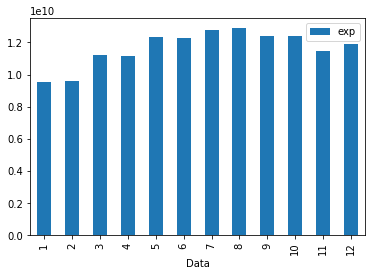

In [ ]:
# Análise dos períodos de sazonalidade
dfexp.groupby(dfexp.index.month).mean().plot(kind='bar')

In [ ]:
df.index.freq = 'MS'

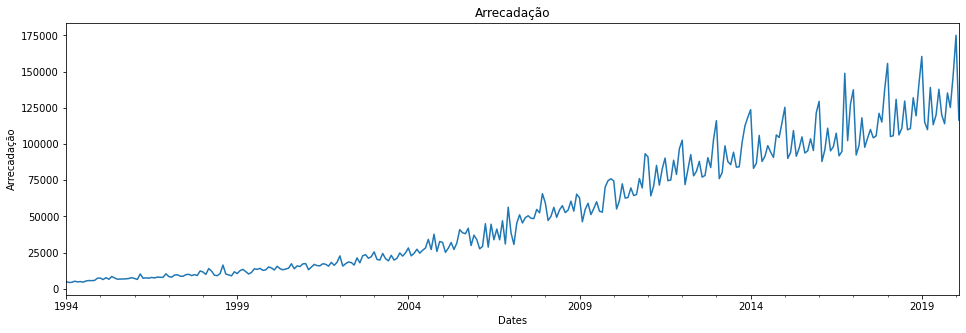

In [ ]:
ax = df['y'].plot(figsize = (16,5), title = "Arrecadação")
ax.set(xlabel='Dates', ylabel='Arrecadação');

When we look at plot we can sey there is a seasonality in data. That's why we will use SARIMA (Seasonal ARIMA) instead of ARIMA.

> Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.
> It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

> There are four seasonal elements that are not part of ARIMA that must be configured; they are:<br>
**P:** Seasonal autoregressive order.<br>
**D:** Seasonal difference order.<br>
**Q:** Seasonal moving average order.<br>
**m:** The number of time steps for a single seasonal period.<br>

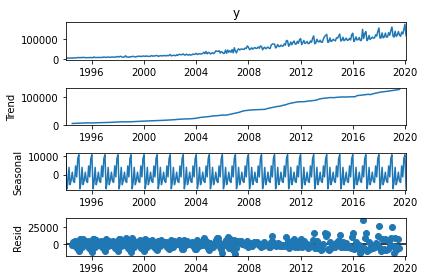

In [ ]:
a = seasonal_decompose(df["y"], model = "add")
a.plot();

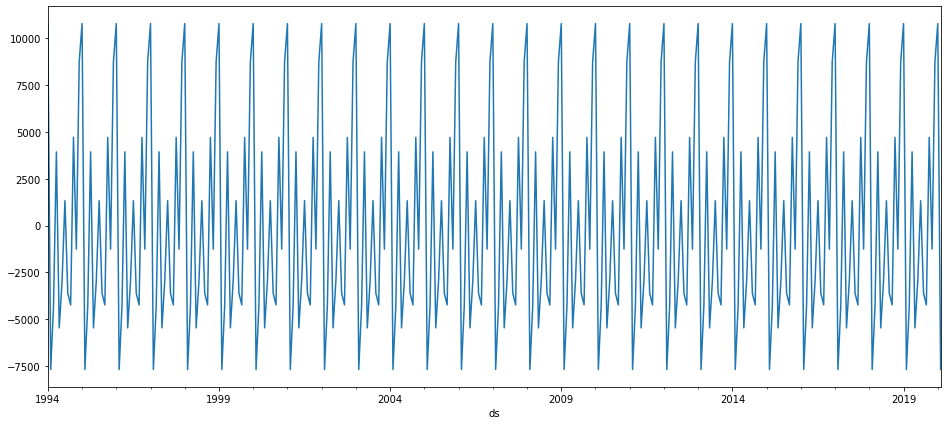

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

## **MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL**

MODELO PREDITIVO ARIMA

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
auto_arima(df['y'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  314
Model:             SARIMAX(1, 1, 0)x(3, 0, [1], 12)   Log Likelihood               -3149.986
Date:                              Tue, 02 Feb 2021   AIC                           6313.972
Time:                                      20:20:16   BIC                           6340.195
Sample:                                           0   HQIC                          6324.452
                                              - 314                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     62.5907    227.608      0.275      0.783    -383.514     508.695
ar.L1         -0.4892      0.030    -16.521      0.000      -0.547      -0.431
ar.S.L12       0.7638      0.344      2.218      0.027       0.089       1.439
ar.S.L24       0.1585      0.179      0.888      0.375      -0.191       0.509
ar.S.L36       0.0462      0.157      0.293      0.769      -0.262       0.355
ma.S.L12      -0.3141      0.349     -0.899      0.368      -0.999       0.370
sigma2      2.955e+07      0.016   1.86e+09      0.000    2.95e+07    2.95e+07
===================================================================================
Ljung-Box (L1) (Q):                   7.76   Jarque-Bera (JB):              2867.26
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              20.58   Skew:                             1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+24. Standard errors may be unstable.
"""

As we can see best arima model chosen by auto_arima() is SARIMAX(2, 1, 1)x(4, 0, 3, 12)

Let's split the data into train and test set

In [ ]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [ ]:
test_data

,y
ds,
2019-03-01,109854
2019-04-01,139030
2019-05-01,113278
2019-06-01,119946
2019-07-01,137735
2019-08-01,119951
2019-09-01,113933
2019-10-01,135202
2019-11-01,125161


In [ ]:
arima_model = SARIMAX(train_data['y'], order = (0,1,1), seasonal_order = (1,1,2,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  302
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -2862.936
Date:                                 Tue, 02 Feb 2021   AIC                           5735.872
Time:                                         20:29:38   BIC                           5754.204
Sample:                                     01-01-1994   HQIC                          5743.217
                                          - 02-01-2019                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8217      0.034    -24.127      0.000      -0.888      -0.755
ar.S.L12       0.9963      0.020     50.945      0.000       0.958       1.035
ma.S.L12      -1.6092      0.049    -32.776      0.000      -1.705      -1.513
ma.S.L24       0.6200      0.033     18.517      0.000       0.554       0.686
sigma2      2.272e+07   3.69e-09   6.15e+15      0.000    2.27e+07    2.27e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              3694.51
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):              17.07   Skew:                             2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+30. Standard errors may be unstable.
"""

In [ ]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2019-03-01    114538.221536
2019-04-01    136135.889426
2019-05-01    114385.365859
2019-06-01    119389.395546
2019-07-01    131883.349396
2019-08-01    117439.879777
2019-09-01    118629.422669
2019-10-01    143127.237904
2019-11-01    128216.866629
2019-12-01    151476.405793
2020-01-01    167102.885630
2020-02-01    118813.306616
Freq: MS, Name: ARIMA Predictions, dtype: float64

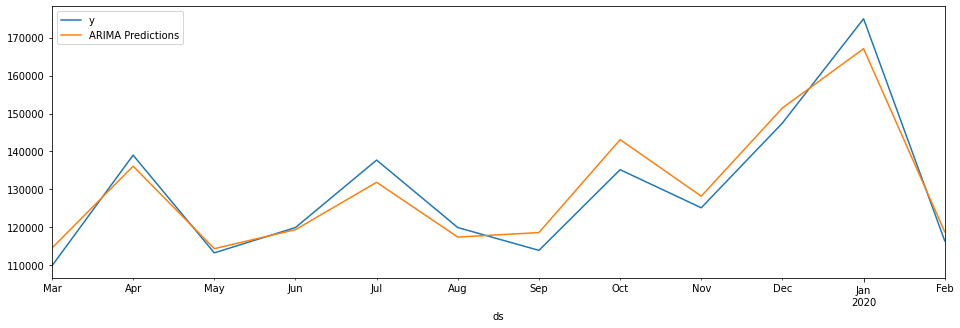

In [ ]:
test_data['y'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [ ]:
arima_rmse_error = rmse(test_data['y'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 20859322.263930578
RMSE Error: 4567.200703267876
Mean: 54008.87898089172


In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

## LSTM Forecast

First we'll scale our train and test data with MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Before creating LSTM model we should create a Time Series Generator object.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
290/290 [==============================] - 4s 10ms/step - loss: 0.0269
Epoch 2/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0047
Epoch 3/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0073
Epoch 4/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 5/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0052
Epoch 6/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 7/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 8/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0046
Epoch 9/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0050
Epoch 10/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 11/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0020
Epoch 12/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 13/20
2

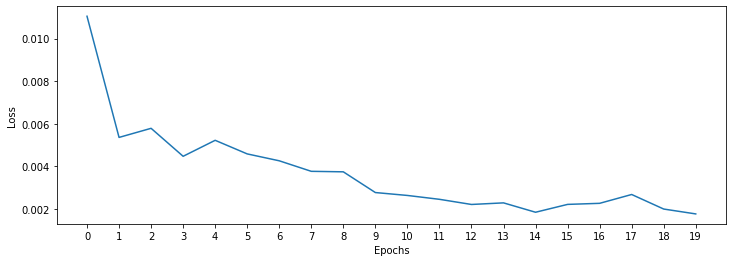

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

As you know we scaled our data that's why we have to inverse it to see true predictions.

In [ ]:
lstm_predictions_scaled

[array([0.7392362], dtype=float32),
 array([0.85764617], dtype=float32),
 array([0.74661165], dtype=float32),
 array([0.7634965], dtype=float32),
 array([0.8542656], dtype=float32),
 array([0.7650373], dtype=float32),
 array([0.7677406], dtype=float32),
 array([0.87268454], dtype=float32),
 array([0.8191243], dtype=float32),
 array([0.93390137], dtype=float32),
 array([1.0454565], dtype=float32),
 array([0.8151505], dtype=float32)]

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
lstm_predictions

array([[119725.20006078],
       [138206.9867273 ],
       [120876.38690966],
       [123511.82704008],
       [137679.33306229],
       [123752.31661534],
       [124174.25720322],
       [140554.22080153],
       [132194.37521476],
       [150109.12746686],
       [167520.99136341],
       [131574.13538909]])

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions

In [ ]:
test_data

,y,ARIMA_Predictions,LSTM_Predictions
ds,,,
2019-03-01,109854,114538.221536,119725.200061
2019-04-01,139030,136135.889426,138206.986727
2019-05-01,113278,114385.365859,120876.386910
2019-06-01,119946,119389.395546,123511.827040
2019-07-01,137735,131883.349396,137679.333062
2019-08-01,119951,117439.879777,123752.316615
2019-09-01,113933,118629.422669,124174.257203
2019-10-01,135202,143127.237904,140554.220802
2019-11-01,125161,128216.866629,132194.375215


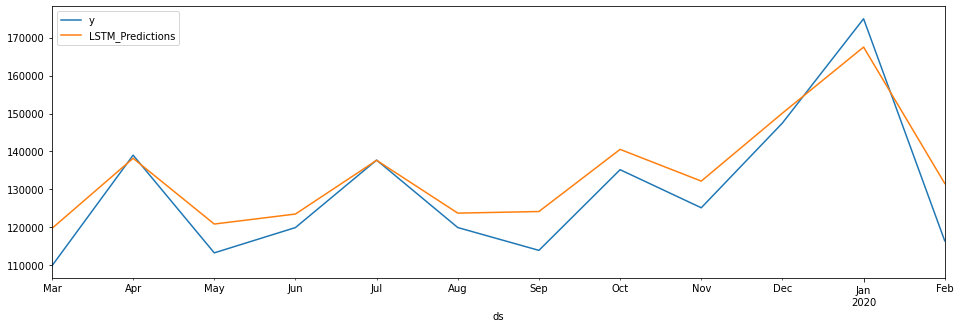

In [ ]:
test_data['y'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error = rmse(test_data['y'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 54830652.711122535
RMSE Error: 7404.772292996087
Mean: 54008.87898089172


## Prophet Forecast

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 1994-01-01 to 2020-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       314 non-null    int64
dtypes: int64(1)
memory usage: 4.9 KB


In [ ]:
df_pr = df.copy()
df_pr = df.reset_index()

In [ ]:
df_pr.columns = ['ds','y'] # To use prophet column names should be like that

In [ ]:
train_data_pr = df_pr.iloc[:len(df)-12]
test_data_pr = df_pr.iloc[len(df)-12:]

In [ ]:
from fbprophet import Prophet

In [ ]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
309,2019-10-01,130300.817556,123796.961403,140471.688298,130213.223521,130372.631404,1418.326357,1418.326357,1418.326357,1418.326357,1418.326357,1418.326357,0.0,0.0,0.0,131719.143913
310,2019-11-01,130823.588015,121153.277475,137842.520112,130712.960849,130917.072292,-1459.864093,-1459.864093,-1459.864093,-1459.864093,-1459.864093,-1459.864093,0.0,0.0,0.0,129363.723922
311,2019-12-01,131329.494911,132000.857045,149278.147305,131187.374581,131447.812317,8765.316037,8765.316037,8765.316037,8765.316037,8765.316037,8765.316037,0.0,0.0,0.0,140094.810948
312,2020-01-01,131852.265370,133220.860260,149326.897148,131680.178460,131995.601113,9478.612595,9478.612595,9478.612595,9478.612595,9478.612595,9478.612595,0.0,0.0,0.0,141330.877965
313,2020-02-01,132375.035829,117036.781621,133945.566286,132161.452066,132548.654124,-7083.369400,-7083.369400,-7083.369400,-7083.369400,-7083.369400,-7083.369400,0.0,0.0,0.0,125291.666429


In [ ]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})

In [ ]:
prophet_pred = prophet_pred.set_index("Date")

In [ ]:
prophet_pred.index.freq = "MS"

In [ ]:
prophet_pred

,Pred
Date,
2019-03-01,121630.326801
2019-04-01,129922.933794
2019-05-01,121583.844712
2019-06-01,125117.610239
2019-07-01,129526.413885
2019-08-01,125666.318949
2019-09-01,126033.950733
2019-10-01,131719.143913
2019-11-01,129363.723922


In [ ]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [ ]:
import seaborn as sns

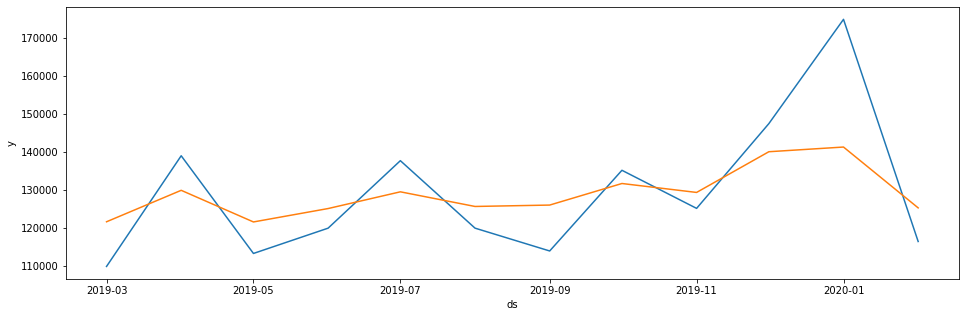

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["y"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [ ]:
prophet_rmse_error = rmse(test_data['y'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 155000805.03770056
RMSE Error: 12449.931929038832
Mean: 54008.87898089172


In [ ]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

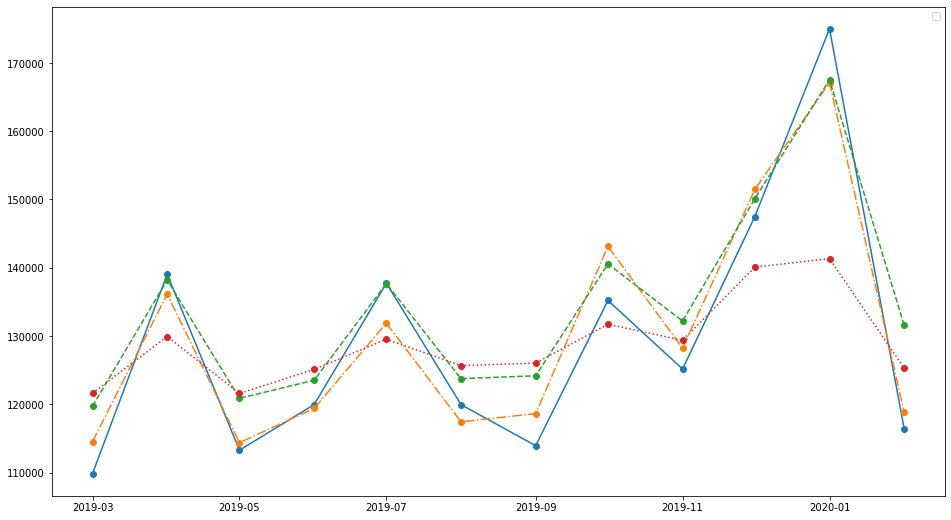

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["y"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
print(f"Mean: {test_data['y'].mean()}")
errors

Mean: 129417.66666666667


,Models,RMSE Errors,MSE Errors
0,ARIMA,4567.200703,2.085932e+07
1,LSTM,7404.772293,5.483065e+07
2,Prophet,12449.931929,1.550008e+08


In [ ]:
test_data

,y,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
ds,,,,
2019-03-01,109854,114538.221536,119725.200061,121630.326801
2019-04-01,139030,136135.889426,138206.986727,129922.933794
2019-05-01,113278,114385.365859,120876.386910,121583.844712
2019-06-01,119946,119389.395546,123511.827040,125117.610239
2019-07-01,137735,131883.349396,137679.333062,129526.413885
2019-08-01,119951,117439.879777,123752.316615,125666.318949
2019-09-01,113933,118629.422669,124174.257203,126033.950733
2019-10-01,135202,143127.237904,140554.220802,131719.143913
2019-11-01,125161,128216.866629,132194.375215,129363.723922


Don't forget they are just quick and basic predictions so you can improve these models with tuning and according to your data and business knowledge.

<br>

Thanks!